In [1]:
print("all ok!!")

all ok!!


In [45]:
evaluator_llm=ChatGroq(model="openai/gpt-oss-20b")

In [2]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

from typing import Annotated, Any, Dict, List, Optional
from IPython.display import Image, display
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import gradio as gr
import requests
import os
import asyncio
import uuid

In [3]:
load_dotenv()

True

In [106]:
# llm = ChatGoogleGenerativeAI(
#     model="gemini-2.5-pro",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=10
# )

## structured output

In [4]:
class EvaluatorOutput(BaseModel):
    feedback: str =Field(description="feedback on the assistant`s response")
    success_criteria_met: bool =Field(description="Whether the success criteria have been met")
    user_input_needed: bool =Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [5]:
# Defining a state

from typing import Optional


class State(TypedDict):
    messages: Annotated[list[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

In [6]:
serper=GoogleSerperAPIWrapper()
search_tool=Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need to more information from online search"
        )

In [7]:
tools=[search_tool]

In [8]:
worker_llm=ChatOpenAI(model="gpt-4o-mini")
worker_llm_with_tools=worker_llm.bind_tools(tools)

evaluator_llm=ChatOpenAI(model="gpt-4o-mini")
evaluator_llm_with_output=evaluator_llm.with_structured_output(EvaluatorOutput)

In [ ]:
# worker_llm_with_tools=llm.bind_tools(tools)

# evaluator_llm_with_output=llm.with_structured_output(EvaluatorOutput)

In [18]:
def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
    
    SUCCESS CRITERIA: {state["success_criteria"]}
    
    Follow these rules:
    1. FIRST attempt to answer the question directly using your knowledge
    2. If you need current information or additional data, use the search tool
    3. Only ask clarifying questions if the request is truly ambiguous or missing key information
    4. Provide complete, helpful answers that meet the success criteria
    5. When you have a final answer, state it clearly without additional questions
    
    Examples:
    - For "what is current USD/GBP exchange rate": Use search tool and provide the rate
    - For "what are trending AI fields": Provide a comprehensive list based on your knowledge
    - Only ask for clarification if the question is unclear like "tell me about it"
    """

    if state.get("feedback_on_work"):
        system_message += f"""
        PREVIOUS FEEDBACK: {state["feedback_on_work"]}
        Use this feedback to improve your response. Address the issues mentioned.
        """

    found_system_message = False
    messages = state["messages"]
    
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
            
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages

    response = worker_llm_with_tools.invoke(messages)

    return {
        "messages": [response]
    }

In [ ]:
# def worker(state: State) -> Dict[str, Any]:
#     system_message = f"""You are a helpful assistant that can use tools to complete tasks.
    
#     SUCCESS CRITERIA: {state["success_criteria"]}
    
#     Follow these rules:
#     1. FIRST attempt to answer the question directly using your knowledge
#     2. If you need current information or additional data, use the search tool
#     3. Only ask clarifying questions if the request is truly ambiguous
#     4. When using tools, make sure to provide the tool calls properly
#     5. Provide complete, helpful answers that meet the success criteria
#     """

#     if state.get("feedback_on_work"):
#         system_message += f"""
#         PREVIOUS FEEDBACK: {state["feedback_on_work"]}
#         Use this feedback to improve your response.
#         """

#     # Filter out system messages and prepare context
#     conversation_messages = [msg for msg in state["messages"] if not isinstance(msg, SystemMessage)]
    
#     # Add system message at the beginning
#     messages = [SystemMessage(content=system_message)] + conversation_messages

#     try:
#         response = worker_llm_with_tools.invoke(messages)
#         return {"messages": [response]}
#     except Exception as e:
#         print(f"Error in worker: {e}")
#         # Fallback response
#         return {"messages": [AIMessage(content=f"I encountered an error. Please try again. Error: {str(e)}")]}

In [19]:
def work_router(state: State) -> str:
    last_response=state['messages'][-1]
    
    if hasattr(last_response, "tool_calls") and last_response.tool_calls:
        return "tools"
    else:
        return "evaluator"

In [20]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"

    for message in messages:
        if isinstance(message, HumanMessage):
            conversation +=f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text=message.content or "[tools use]"
            conversation += f"Assistant: {text}\n"
    
    return conversation

In [30]:
def evaluator(state: State) -> State:
    last_message = state['messages'][-1]
    
    used_tools = hasattr(last_message, "tool_calls") and last_message.tool_calls
    
    # MODIFIED SYSTEM MESSAGE
    system_message = """You are an expert evaluator. Your job is to determine if the assistant is making progress.
    
    CRITICAL RULE: If the assistant's response is not improving, is repetitive, or seems stuck after receiving feedback,
    it is YOUR RESPONSIBILITY to stop the loop. In this case, you MUST set 'user_input_needed' to True and provide feedback
    explaining that the assistant is stuck and requires clarification from the user.
    
    Consider these as POSITIVE progress:
    - Assistant used tools to gather information.
    - Assistant provided a substantive answer that is closer to the goal.
    
    Only consider user input needed if:
    - The assistant is stuck and repeating itself (as per the CRITICAL RULE).
    - The original question is truly ambiguous and cannot be answered without more information."""

    user_message = f"""
    CONVERSATION HISTORY:
    {format_conversation(state["messages"])}
    
    SUCCESS CRITERIA: {state["success_criteria"]}
    
    LAST RESPONSE: {last_message.content}
    
    Evaluate whether:
    1. The response makes progress toward the success criteria.
    2. The assistant needs clarification (especially if it seems stuck).
    3. The success criteria is fully met.
    """

    if state.get("feedback_on_work"):
        user_message += f"\\nPREVIOUS FEEDBACK: {state['feedback_on_work']}"

    evaluator_message = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    evaluation_result = evaluator_llm_with_output.invoke(evaluator_message)

    new_state = {
        "feedback_on_work": evaluation_result.feedback,
        "success_criteria_met": evaluation_result.success_criteria_met,
        "user_input_needed": evaluation_result.user_input_needed,
        # Adding the feedback to the message history is better for context
        "messages": [AIMessage(content=f"Evaluator feedback: {evaluation_result.feedback}")]
    }

    return new_state

In [31]:
def router_based_on_evaluation(state: State) -> str:
    if state.get('success_criteria_met', False) or state.get('user_input_needed', False):
        return "END"
    else:
        return "worker"  # This was missing the return statement

In [32]:
# setting up Graph Buillder
graph_builder=StateGraph(State)

# adding Nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=[search_tool]))
graph_builder.add_node("evaluator", evaluator)

# adding Edges
graph_builder.add_edge(START, "worker")
graph_builder.add_conditional_edges("worker", work_router, {"tools":"tools", "evaluator":"evaluator"})
graph_builder.add_edge("tools","worker")
graph_builder.add_conditional_edges("evaluator", router_based_on_evaluation, {"worker":"worker", "END":END})

# Compiling the graph
memory=MemorySaver()
graph=graph_builder.compile(checkpointer=memory)

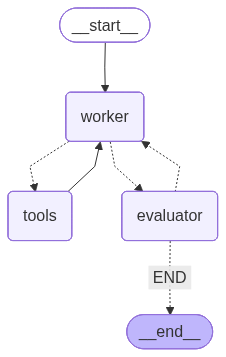

In [33]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

async def process_message(message, success_criteria, history, thread):
    config={"configurable":{"thread_id":thread}}

    state={
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }

    result = await graph.ainvoke(state, config=config)
    user={"role":"user", "content": message}
    reply={"role":"assistant", "content": result["messages"][-2].content}
    feedback={"role":"assistant", "content": result["messages"][-1].content}

    return history + [user, reply, feedback]


async def reset():
    return "", "", None, make_thread_id()

# Launching Sidekick UI

In [35]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread=gr.State(make_thread_id())

    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to Sidekick")
        with gr.Row():
            # Instead of empty or vague criteria, provide better defaults
                success_criteria = gr.Textbox(
                    show_label=False, 
                    placeholder="Success criteria (e.g.: Provide current exchange rate with source)",
                    value="Provide accurate, helpful information that addresses the user's question"
                    )
    with gr.Row():
        reset_button = gr.Button("Reset",variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])


demo.launch(share=False, debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
